Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.510468
RMSE: 0.5105
R² Score: 0.8011


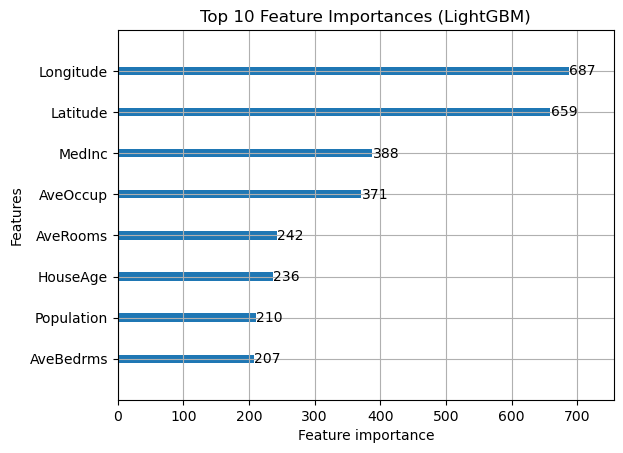

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# ==================== Introduce missing values randomly ===================
rng = np.random.default_rng(42)
mask = rng.random(X.shape) < 0.05
X = X.mask(mask)

# ======================  Fill missing values with median ================
X = X.fillna(X.median())


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =================== Create LightGBM datasets =========================
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

#======================  LightGBM parameters for regression ==============
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42
}

# ==============  Train model ==================
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)],
)


y_pred = model.predict(X_test, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
lgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances (LightGBM)")
plt.show()
